In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
print(tf.__version__)
if tf.__version__ != '1.13.1':
  !pip install tensorflow==1.13.1

1.13.1


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

data_folder_path = '/content/gdrive/My Drive/model'

train_seq_path = 'train_word2vec_w5_whole_data.pkl'
test_seq_path = 'test_word2vec_w5_whole_data.pkl'

embedding_matrix_path = 'word_seg_vectors_arr_whole_data.pkl' #已替换

train_labels_path = 'train_label.pkl'


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
import pickle

train_seq = pickle.load(open(os.path.join(data_folder_path, train_seq_path), 'rb' ) )
test_seq = pickle.load(open(os.path.join(data_folder_path, test_seq_path), 'rb' ))

train_labels = pickle.load(open(os.path.join(data_folder_path, train_labels_path), 'rb'))
embedding_matrix = pickle.load(open(os.path.join(data_folder_path, embedding_matrix_path), 'rb'))

In [0]:
np.max(test_seq)

301

In [0]:
train_labels = train_labels.astype(np.float32)

In [0]:
train_labels

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [0]:
for i in range(len(train_labels)):
    for j in range(len(train_labels[i])):
        if train_labels[i][j] == 0:
            train_labels[i][j] = 0.005 / 7 
      
        else:
            train_labels[i][j] = 0.995

In [0]:
train_labels

array([[7.142857e-04, 7.142857e-04, 7.142857e-04, ..., 9.950000e-01,
        7.142857e-04, 7.142857e-04],
       [7.142857e-04, 7.142857e-04, 9.950000e-01, ..., 7.142857e-04,
        7.142857e-04, 7.142857e-04],
       [9.950000e-01, 7.142857e-04, 7.142857e-04, ..., 7.142857e-04,
        7.142857e-04, 7.142857e-04],
       ...,
       [9.950000e-01, 7.142857e-04, 7.142857e-04, ..., 7.142857e-04,
        7.142857e-04, 7.142857e-04],
       [7.142857e-04, 9.950000e-01, 7.142857e-04, ..., 7.142857e-04,
        7.142857e-04, 7.142857e-04],
       [7.142857e-04, 7.142857e-04, 9.950000e-01, ..., 7.142857e-04,
        7.142857e-04, 7.142857e-04]], dtype=float32)

In [0]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Dense, Input, Embedding, Dropout, Activation
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Flatten, GlobalAveragePooling1D
from tensorflow.keras.layers import SpatialDropout1D, BatchNormalization
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [0]:
def TextCNN_add_pool_wordvec_not_trainable(max_len, max_cnt, embed_size,
            num_filters, kernel_size,
            conv_action,
            mask_zero, embedding_matrix):
    _input = Input(shape=(max_len,), dtype='int32')
    _embed = Embedding(max_cnt, embed_size, input_length=max_len, mask_zero=mask_zero, weights=[embedding_matrix], trainable=False)(_input)
    _embed = SpatialDropout1D(0.2)(_embed)
    warppers = []
#     print('warppers is', warppers)
    
    for _kernel_size in kernel_size:
        conv1d = Conv1D(filters=num_filters, kernel_size=_kernel_size, activation=conv_action)(_embed)
        warppers.append(GlobalMaxPooling1D()(conv1d))
        warppers.append(GlobalAveragePooling1D()(conv1d))
#         warppers.append(GlobalMaxPooling1D()(conv1d))
                        
    fc = concatenate(warppers)
    fc = Dropout(0.5)(fc)
    #fc = BatchNormalization()(fc)
    fc = Dense(256, activation='relu')(fc)
    fc = Dropout(0.25)(fc)
    #fc = BatchNormalization()(fc) 
    preds = Dense(8, activation = 'softmax')(fc)
    
    model = Model(inputs=_input, outputs=preds)
    #model.summary()
    return model

In [0]:
class_weights=[1, 0.8, 0.5, 0.81,  1.22, 1, 1.22, 0.81]
from sklearn.metrics import accuracy_score

In [0]:
# from sklearn.utils import class_weight
# from sklearn.metrics import accuracy_score

# class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(np.argmax(train_labels, axis = 1)),
#                                                  np.argmax(train_labels, axis = 1))
# print(class_weights)

In [0]:
class_weights

[1, 0.8, 0.5, 0.81, 1.22, 1, 1.22, 0.81]

FOLD:  1
2780 11107
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50000)        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50000, 100)   30200       input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 50000, 100)   0           embedding[0][0]                  
__________________________________________________________________________________________________
c

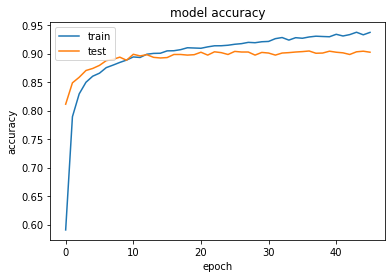

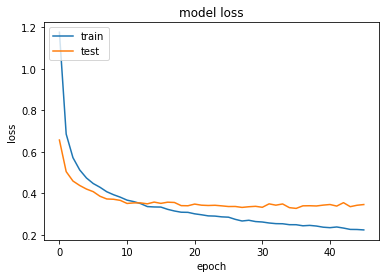

11107/11107 [==============================] - 228s 21ms/sample
train confuse matrix is
[[3976    0    1    0    0    4    0    1]
 [   0  397    0    0    0    4    0    0]
 [   2    0  947    0    0    5    0    2]
 [   3    8    1  577   17   13    5   32]
 [   0    0    0    8   65    3    1    3]
 [   2    0    1   43    1 3380    1    3]
 [   1    0    1    2    0    3  381   24]
 [   5   20   12  103   21   23   23  982]]
val confuse matrix is
[[990   0   1   0   0   2   0   3]
 [  2  96   1   0   0   1   0   1]
 [ 11   0 213   0   0   2   2  12]
 [  0   1   2 125   4  10   1  21]
 [  1   0   0   7   5   2   0   5]
 [  4   0   3  12   0 834   3   2]
 [  5   0   3   3   0  11  54  27]
 [ 13   3  13  44   8   5  22 190]]
train accuracy is 0.9638066084451247
valid accuracy is 0.9017985611510791
FOLD:  2
2779 11108
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connec

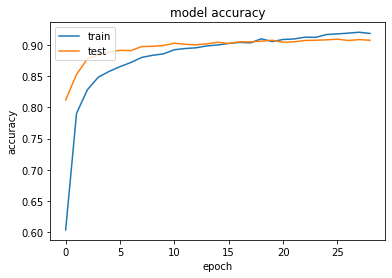

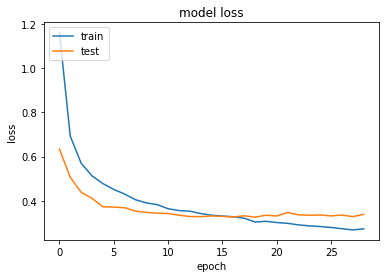

11108/11108 [==============================] - 222s 20ms/sample
train confuse matrix is
[[3972    0    2    0    0    6    0    2]
 [   1  397    0    0    0    3    0    0]
 [   5    0  940    0    0    9    0    3]
 [   1    8    4  523    0   18    3   99]
 [   2    0    1   52    3    4    2   16]
 [   4    0    1   48    0 3367    1   10]
 [   2    0    3    2    0   11  299   95]
 [   6   18   19  113    0   29   19  985]]
val confuse matrix is
[[985   0   5   0   0   1   1   4]
 [  2  97   0   0   0   2   0   0]
 [  5   0 228   0   0   2   0   4]
 [  2   1   2 110   0   5   2  42]
 [  0   0   0  12   0   0   0   8]
 [  3   0   4   9   0 834   0   8]
 [  5   0   2   1   0   3  59  33]
 [ 20   6  15  29   0   4  14 210]]
train accuracy is 0.9440043212099388
valid accuracy is 0.9078805325656711
FOLD:  3
2777 11110
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connec

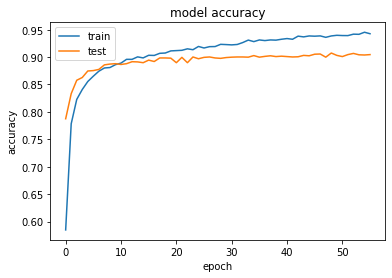

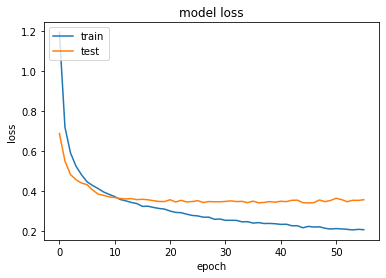

11110/11110 [==============================] - 207s 19ms/sample
train confuse matrix is
[[3978    0    1    0    0    1    0    2]
 [   0  399    0    0    0    3    0    0]
 [   0    0  951    0    0    3    0    3]
 [   1    7    2  597    7   16    2   24]
 [   0    0    0   13   59    4    1    3]
 [   1    0    2   40    0 3384    2    2]
 [   0    0    0    3    0    2  399    8]
 [   2   19   10   97   16   18   38  990]]
val confuse matrix is
[[991   0   1   0   0   3   0   1]
 [  3  95   0   0   0   2   0   0]
 [  9   0 213   0   0   6   0  11]
 [  2   2   1 130   5   4   1  19]
 [  3   0   0   5   8   1   1   2]
 [  4   0   1  14   1 831   3   4]
 [  8   0   1   3   0   4  69  18]
 [ 12   5  11  54   6   9  26 174]]
train accuracy is 0.9682268226822682
valid accuracy is 0.9042131796903133
FOLD:  4
2776 11111
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connec

KeyboardInterrupt: ignored

In [14]:
seeds = [0]
total_test = np.zeros(shape = (len(test_seq), 8))
for seed in seeds:
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    max_len = 50000
    max_cnt = 302
    embed_size = 100
    num_filters = 24
    kernel_size_short = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
    conv_action = 'relu'
    mask_zero = False
    TRAIN = True


    tf.logging.set_verbosity(0)

    meta_train = np.zeros(shape = (len(train_seq), 8))
    meta_test = np.zeros(shape = (len(test_seq), 8))

    multi_train_labels = [np.argmax(i) for i in train_labels]
    split_data = skf.split(train_seq, multi_train_labels)

    for i,(tr_ind,te_ind) in enumerate(split_data):
        print('FOLD: ', i + 1)
        print(len(te_ind),len(tr_ind))
        model = TextCNN_add_pool_wordvec_not_trainable(max_len,max_cnt,embed_size,num_filters,kernel_size_short,conv_action,mask_zero, embedding_matrix)
        model_name = 'benchmark_cnn_fold_' + str(i)
        X_train, X_train_label = train_seq[tr_ind], train_labels[tr_ind]
        X_val, X_val_label = train_seq[te_ind], train_labels[te_ind]
        model_save_path = '%s_%s.ckpt'%(model_name, embed_size)
        early_stopping = EarlyStopping(monitor='val_loss', patience=10)
        model_checkpoint = ModelCheckpoint(model_save_path, save_best_only=True, save_weights_only=True)

        strategy = tf.contrib.tpu.TPUDistributionStrategy(
            tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR']))
        model = tf.contrib.tpu.keras_to_tpu_model(model, strategy)
        model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

        if TRAIN:
            history = model.fit(X_train, X_train_label,
                    validation_data=(X_val, X_val_label),
                    epochs=100, batch_size=64,
                    shuffle=True,
                    callbacks=[early_stopping],
                    class_weight=class_weights
                    )
            
            # summarize history for accuracy
            plt.plot(history.history['acc'])
            plt.plot(history.history['val_acc'])
            plt.title('model accuracy')
            plt.ylabel('accuracy')
            plt.xlabel('epoch')
            plt.legend(['train', 'test'], loc='upper left')
            plt.show()
            # summarize history for loss
            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])
            plt.title('model loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train', 'test'], loc='upper left')
            plt.show()
        
        #model.load_weights(model_save_path)
        #model.save_weights('/tmp/%s.h5' % model_name, overwrite=True)
        cpu_model = model.sync_to_cpu()
        pred_val = cpu_model.predict(X_val, batch_size=64, verbose=1)
        pred_test = cpu_model.predict(test_seq, batch_size=64, verbose=1)
        pred_train = cpu_model.predict(X_train, batch_size=64, verbose=1)
        
        print('train confuse matrix is')
        print(confusion_matrix(X_train_label.argmax(1), pred_train.argmax(1)))
        print('val confuse matrix is')
        print(confusion_matrix(X_val_label.argmax(1), pred_val.argmax(1)))
        print('train accuracy is', accuracy_score(X_train_label.argmax(1), pred_train.argmax(1)))
        print('valid accuracy is', accuracy_score(X_val_label.argmax(1), pred_val.argmax(1)))
        #print(confusion_matrix(binary_labels.argmax(1), pred_train.argmax(1)))
            
        meta_train[te_ind] = pred_val
        meta_test += pred_test
        tf.keras.backend.clear_session()
    meta_test /= 5.0
    total_test += meta_test

total_test /= len(seeds)

In [0]:
import pandas as pd

test_df = pd.DataFrame(meta_test)
test_df.columns = ['prob0', 'prob1', 'prob2', 'prob3', 'prob4', 'prob5', 'prob6', 'prob7']
test_df.index += 1 
test_df.index.name = 'file_id'

test_df.to_csv(os.path.join(data_folder_path, 'secruity_submit_keep_50000_word2vec_adam_new_weights_seed3.csv'))

In [0]:
from google.colab import files
files.download(os.path.join(data_folder_path, 'secruity_submit_keep_50000_word2vec_adam_new_weights_seed3.csv'))